In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
data = load_dataset("valhalla/emoji-dataset")["train"]

In [ ]:
count = 0
for row in data:
  if "man" in row["text"]: #all emojis with the term man or woman
    count += 1
count

610

In [ ]:
def contains_man(row):
  return "man" in row["text"]

filtered = data.filter(contains_man)

Filter:   0%|          | 0/2749 [00:00<?, ? examples/s]

In [ ]:
df = filtered.to_pandas()

In [ ]:
!pip install pillow

In [ ]:
import pandas as pd
import PIL

In [17]:
from PIL import Image, ImageOps
import numpy as np
import io
import random
from IPython.display import display

def process_image(bytes_arr):
  image = Image.open(io.BytesIO(bytes_arr))
  size = (64,64)
  resized_image = image.resize(size, Image.ANTIALIAS)
  image_array = np.array(resized_image)
  return image_array

def augment_image(og_array):
  og = Image.fromarray(og_array)
  augmentations = ["h", "v", "r"] #horizontal flip, vertical_flip, rotate
  augmentation = random.choice(augmentations)
  aug = None
  if augmentation == "h":
    aug = ImageOps.mirror(og)
  elif augmentation == "v":
    aug = ImageOps.flip(og)
  else:
    d = random.choice([90,180,270])
    aug = og.rotate(d)
  aug_array = np.array(aug)
  return aug_array

def show_image(image_array):
  image = Image.fromarray(image_array)
  display(image)


In [ ]:
augmented_dataset = []
for image in df["image"]:
  bytes_arr = image["bytes"]
  image_arr = process_image(bytes_arr)
  augmented_dataset.append(image_arr)
  augmented_dataset.append(augment_image(image_arr))
final_dataset = np.array(augmented_dataset)





<ipython-input-35-cc9e2b5cb8e4>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(size, Image.ANTIALIAS)


In [ ]:
np.save("processed_data.npy", final_dataset)

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Output: (16, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (16, 32, 32)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (32, 16, 16)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Output: (16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # Output: (3, 64, 64)
            nn.Sigmoid()  # Use sigmoid to scale the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [52]:
import numpy as np

processed_data = np.load("processed_data.npy")
np.random.shuffle(processed_data)

X_train, X_valid, X_test = processed_data[:600], processed_data[600:800], processed_data[800:1000]

In [53]:
def normalize_create_tensor(data):
  """
  Normalize data and create a tensor
  """
  n = len(data)
  data_scaled = data.astype(np.float32)/255.0
  data_reshaped = np.transpose(data_scaled, (0,3,1,2))
  data_tensor = torch.tensor(data_reshaped)
  print(f'Shape: {data_tensor.shape}')  # Expected shape: (N, 3, 64, 64)
  print(f'Type: {data_tensor.dtype}')   # Should be torch.float32
  return data_tensor


In [54]:
X_train_tensor = normalize_create_tensor(X_train)
X_valid_tensor = normalize_create_tensor(X_valid)
X_test_tensor = normalize_create_tensor(X_test)

Shape: torch.Size([600, 3, 64, 64])
Type: torch.float32
Shape: torch.Size([200, 3, 64, 64])
Type: torch.float32
Shape: torch.Size([200, 3, 64, 64])
Type: torch.float32


In [57]:
import torch
import torch.optim as optim
import torch.nn as nn

cae = ConvAutoEncoder()

def train_CAE():
  loss_fn = nn.MSELoss()
  lr = 0.005
  optimizer = optim.Adam(cae.parameters(), lr)
  epochs = 250
  losses = []
  for epoch in range(epochs):
    cae.train()
    output = cae.forward(X_train_tensor)
    loss = loss_fn(output, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cae.eval()
    with torch.no_grad():
      valid_output = cae.forward(X_valid_tensor)
      valid_loss = loss_fn(valid_output, X_valid_tensor)
    print(f"epoch: {epoch}, train loss: {loss}, valid loss: {valid_loss}")


train_CAE()



epoch: 0, train loss: 0.1431254744529724, valid loss: 0.14162150025367737
epoch: 1, train loss: 0.14221838116645813, valid loss: 0.14053842425346375
epoch: 2, train loss: 0.1411355584859848, valid loss: 0.13910064101219177
epoch: 3, train loss: 0.13970044255256653, valid loss: 0.1367037147283554
epoch: 4, train loss: 0.13730977475643158, valid loss: 0.13357695937156677
epoch: 5, train loss: 0.13419854640960693, valid loss: 0.13146650791168213
epoch: 6, train loss: 0.13211555778980255, valid loss: 0.12700335681438446
epoch: 7, train loss: 0.1276257038116455, valid loss: 0.12367718666791916
epoch: 8, train loss: 0.12427490204572678, valid loss: 0.11948894709348679
epoch: 9, train loss: 0.12006770074367523, valid loss: 0.11476440727710724
epoch: 10, train loss: 0.11533190310001373, valid loss: 0.11082042753696442
epoch: 11, train loss: 0.11137489229440689, valid loss: 0.10575494170188904
epoch: 12, train loss: 0.10628475248813629, valid loss: 0.10113020241260529
epoch: 13, train loss: 0.1

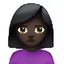

Shape: torch.Size([1, 3, 64, 64])
Type: torch.float32


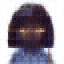

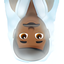

Shape: torch.Size([1, 3, 64, 64])
Type: torch.float32


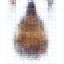

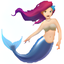

Shape: torch.Size([1, 3, 64, 64])
Type: torch.float32


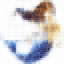

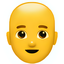

Shape: torch.Size([1, 3, 64, 64])
Type: torch.float32


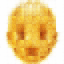

In [58]:
def predict_and_display_image(i):
  image_arr = X_test[i] #np array of image
  show_image(image_arr)
  X = np.array([image_arr])
  norm_X = normalize_create_tensor(X)
  output = cae.forward(norm_X)
  output = output.detach().cpu()
  output_array = (output.numpy()*255).astype(np.uint8) #convert to numpy
  output_array = np.transpose(output_array[0], (1, 2, 0))
  show_image(output_array)


predict_and_display_image(0)
predict_and_display_image(10)
predict_and_display_image(20)
predict_and_display_image(30)
